In [2]:
using Random, Statistics, PyPlot, Polynomials

In [6]:
# Structure representing a 2D point with integer coordinates
struct Point2D
    x::Int64
    y::Int64
end

# Structure representing a square lattice with specified dimensions
struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

# Calculate the total number of sites in the lattice
import Base.length
function length(lat::SquareLattice)
    return lat.Nx * lat.Ny
end

# Convert a 2D point on the lattice to a linear index
function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y - 1) * lat.Nx + r.x
end

# Convert a linear index to a 2D point on the lattice
function IndexToPoint(lat::SquareLattice, ind::Int64)
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind - 1, lat.Nx) + 1
    x = mod(ind - 1, lat.Nx) + 1

    return Point2D(x, y)
end
    
# Find the linear indices of the nearest neighbors of a site on the lattice
function NearestNeighbors(lat::SquareLattice, ind::Int64)
    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64, 4)
    
    xp = mod(r.x, lat.Nx) + 1
    yp = mod(r.y, lat.Ny) + 1
    xm = mod(r.x - 2, lat.Nx) + 1
    ym = mod(r.y - 2, lat.Ny) + 1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y)) # Left neighbor
    nn[2] = PointToIndex(lat, Point2D(xp, r.y)) # Right neighbor
    nn[3] = PointToIndex(lat, Point2D(r.x, ym)) # Upper neighbor
    nn[4] = PointToIndex(lat, Point2D(r.x, yp)) # Lower neighbor
    
    return nn
end

NearestNeighbors (generic function with 1 method)

In [8]:
function IsingConfigurationEnergy(lat::SquareLattice, c::Vector{Int64})
    # Calculate the energy of an Ising configuration on a square lattice.
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        # Energy contribution from the current site
        bond_energy = -4*(c[j]-1/2)*sum(c[nn].-1/2)
        Ec += bond_energy
    end
    return Ec/2  # In the summation above, every bond is included twice
end

IsingConfigurationEnergy (generic function with 1 method)

In [10]:
function IsingMC(lat::SquareLattice, T::Float64, Nsw::Int64, clusterUpdates = false, saveConfigs = false)
    # Perform Ising Monte Carlo simulations.

    # Parameters:
    # - `lat`: SquareLattice object representing the lattice.
    # - `T`: Temperature.
    # - `Nsw`: Number of sweeps to perform.
    # - `clusterUpdates`: Perform cluster updates if true, single-spin updates if false.
    # - `saveConfigs`: Save configurations at each sweep if true.

    c = rand(0:1, length(lat))  # Initialize random spin configuration.

    if saveConfigs
        configs = zeros(Int64, Nsw, length(lat))  # Matrix to store configurations at each sweep.
        configs[1, :] = c  # Save initial configuration.
    end
    
    m = zeros(Float64, Nsw)  # Array to store magnetization at each sweep.
    m[1] = abs(mean(2 * c .- 1))  # Initial magnetization per site.
    
    En = zeros(Float64, Nsw)  # Array to store energy at each sweep.
    En[1] = IsingConfigurationEnergy(lat, c)  # Initial energy.
    
    for i in range(2, stop=Nsw)  # Loop over sweeps.
        
        if clusterUpdates
            IsingWolffUpdate!(lat, c, T)  # Perform cluster update.
            En[i] = IsingConfigurationEnergy(lat, c)  # Calculate new energy.
        else
            dEi = IsingMetropolisSweep!(lat, c, T)  # Perform single-spin Metropolis update and get energy change.
            En[i] = En[i-1] + dEi  # Update total energy.
        end
        
        if saveConfigs
            configs[i, :] = c  # Save current configuration.
        end

        m[i] = abs(mean(2 * c .- 1))  # Update magnetization.

    end
    
    if saveConfigs
        return m, En, configs
    else
        return m, En
    end
    
end

IsingMC (generic function with 3 methods)

In [12]:
function CalculateError(m, Neq, Nsw)
    # Function to calculate the error in the mean magnetization using binning analysis
    
    err = Float64[]

    # Determine the number of sweeps for error analysis
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than the number of sweeps after equilibration

    # Extract the last Nsw2 magnetization values for error analysis
    ml = m[end-Nsw2+1:end]

    # Set the minimum size for the moving block (binning) analysis
    min_size = 2^5

    # Perform the moving block (binning) analysis
    while length(ml) > min_size
        # Compute the standard error of the mean and append to the error array
        push!(err, std(ml) / sqrt(length(ml) - 1))

        # Reduce the size of the data by taking the mean of consecutive pairs (binning)
        ml = map(j -> mean(ml[2*j-1:2*j]), range(1, stop=div(length(ml),2)))
    end

    return err
end

CalculateError (generic function with 1 method)

# Metropolis - local updates

In [14]:
function IsingMetropolisSweep!(lat::SquareLattice, c::Vector{Int64}, T::Float64)
    # Perform a Metropolis sweep for the 2D Ising model on a square lattice.

    # Parameters:
    # - lat::SquareLattice: Square lattice information (Nx, Ny).
    # - c::Vector{Int64}: Ising spin configuration.
    # - T::Float64: Temperature of the system.

    # Returns:
    # - dE::Float64: Total energy change after the Metropolis sweep.
    
    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    dE = 0. # total energy change after a sweep
    
    for j in range(1, length = N)
        ind = rand(1:N) # pick a random site
        
        nn = NearestNeighbors(lat, ind)        

        # energy difference upon flipping the spin
        dEj = 2 * 4 * (c[ind] - 1/2) * sum(c[nn] .- 1/2)
        
        # ratio of Boltzmann weights W(si_flipped)/W(si)
        r = exp(-dEj / T)
        
        if r > rand()
            c[ind] = 1 - c[ind] # accept the move and update the configuration
            dE += dEj
        end    
    end
    
    return dE
end


IsingMetropolisSweep! (generic function with 1 method)

In [15]:
lat = SquareLattice(16,16)
T = 2.2
Nsw = 100000
m,En = IsingMC(lat, T, Nsw);

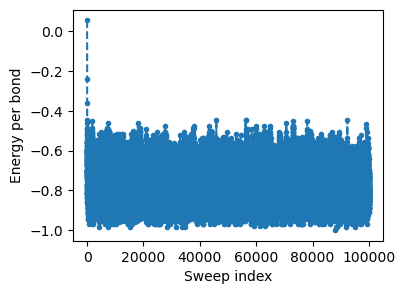

In [16]:
figure(figsize=(4,3))
plot(En/length(lat)/2, "--.") # energy per bond
xlabel("Sweep index")
ylabel("Energy per bond");

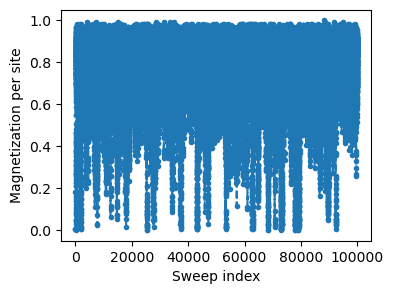

In [17]:
figure(figsize=(4,3))
plot(m, "--.") # magnetization per site
xlabel("Sweep index")
ylabel("Magnetization per site");

Autocorrelation time: 33.0


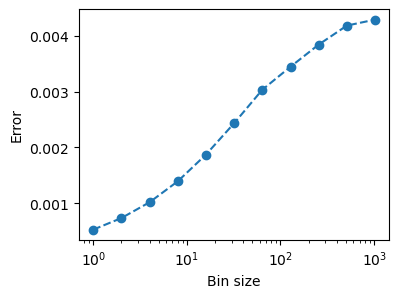

In [18]:
Neq = 1000
err = CalculateError(m, Neq, Nsw)
println("Autocorrelation time: ", round(((err[end]/err[1])^2-1)/2) )
figure(figsize=(4,3))
plot(2 .^ range(0, length= length(err)), err, "--o")
ylabel("Error")
xlabel("Bin size")
xscale("log")

In [26]:
# Define lattice sizes
Ls = Int64[4, 8, 12, 16]

# Define temperature range
Ts = range(0.6, stop=4., step=0.2)

# Define the equilibration steps for each lattice size
Neq = Int64[200, 1000, 2000, 4000] .* 2

# Calculate the total number of steps for each lattice size
Ntot = Neq * 40

# Arrays to store magnetization, error, and autocorrelation time
m = zeros(length(Ts), length(Ls))
dm = zeros(length(Ts), length(Ls))
tau = zeros(length(Ts), length(Ls))

# Loop over lattice sizes
for (j, L) in enumerate(Ls)
    
    # Create a square lattice of size L x L
    lat = SquareLattice(L, L)
    
    # Loop over temperatures
    for (k, T) in enumerate(Ts)
        # Perform Ising Monte Carlo simulation
        mk, En = IsingMC(lat, T, Ntot[j])
        
        # Calculate error and update arrays
        err = CalculateError(mk, Neq[j], Ntot[j])
        m[k, j] = mean(mk[Neq[j]:end])
        dm[k, j] = err[end]
        
        # Autocorrelation time calculation
        tau[k, j] = ((err[end] / err[1])^2 - 1) / 2
    end
end

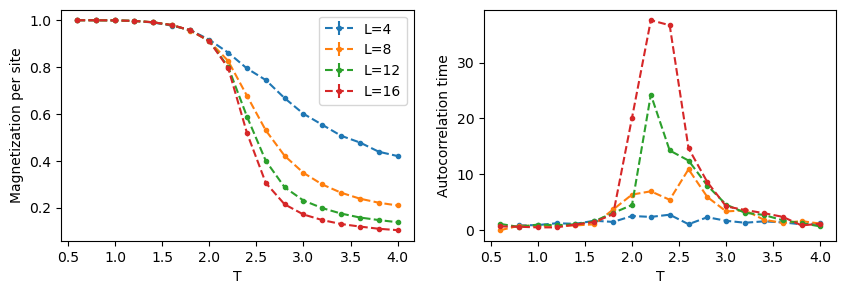

PyObject <matplotlib.legend.Legend object at 0x7fab60ba9610>

In [27]:
fig, ax = subplots(1,2, figsize=(10,3))
for (j, L) in enumerate(Ls)
    ax[1].errorbar(Ts,m[:,j],dm[:,j], marker=".", linestyle="dashed", label="L="*string(L))
end
ax[1].set_xlabel("T")
ax[1].set_ylabel("Magnetization per site");

ax[2].plot(Ts, tau, "--.")
ax[2].set_xlabel("T")
ax[2].set_ylabel("Autocorrelation time");

ax[1].legend()


Dynamical critical exponent using Metropolis local updates is 2.06


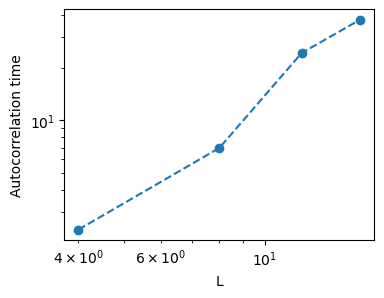

In [28]:
ind_Tc = 9
figure(figsize=(4,3))
plot(Ls, tau[ind_Tc,:], "--o")
xlabel("L")
ylabel("Autocorrelation time");
xscale("log")
yscale("log")

p = fit(log.(Ls), log.(tau[ind_Tc,:]), 1)
println("Dynamical critical exponent using Metropolis local updates is ", round(p[1],digits = 2))

# Wolff - cluster updates

In [25]:
function IsingWolffUpdate!(lat::SquareLattice, c::Vector{Int64}, T::Float64)
    # Get the lattice size
    N = length(lat)
    
    # Check if the configuration size matches the lattice size
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    # Calculate the probability of an aligned spin to join the cluster
    p = 1. - exp(-2 / T)
    
    # Pick a random site
    ind = rand(1:N)
    
    # Arrays to store cluster indices and newly added neighbors
    cluster = Int64[] 
    newlyAdded = Int64[] 
    
    # Add the selected site to the cluster and its neighbors to newlyAdded
    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    # Perform the Wolff algorithm until the cluster is empty
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        
        # Skip if already in the cluster
        if j in cluster
            continue
        end
        
        # If spins match and random number is less than p, add to cluster
        if c[j] == c[ind] && rand() < p
            push!(cluster, j)
            
            # Add neighbors of the current site to newlyAdded
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
        end
    end
    
    # Flip the spins in the cluster
    c[cluster] .= 1 .- c[cluster]
end

IsingWolffUpdate! (generic function with 1 method)

In [29]:
lat = SquareLattice(32,32)
T = 2.2
Nsw = 100000
@time m,En = IsingMC(lat, T, Nsw, true);

 56.245216 seconds (373.91 M allocations: 42.757 GiB, 1.55% gc time, 0.21% compilation time)


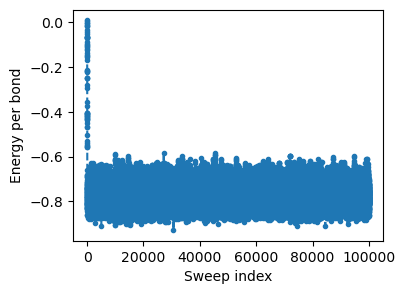

In [30]:
figure(figsize=(4,3))
plot(En/length(lat)/2, "--.") # energy per bond
xlabel("Sweep index")
ylabel("Energy per bond");

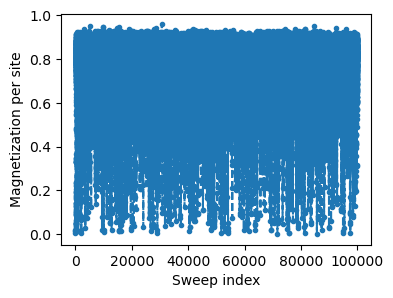

In [31]:
figure(figsize=(4,3))
plot(m, "--.") # magnetization per site
xlabel("Sweep index")
ylabel("Magnetization per site");

Autocorrelation time: 2.0


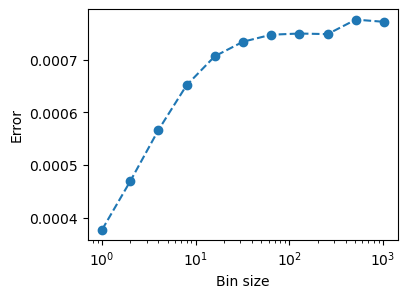

In [32]:
Neq = 100
err = CalculateError(m, Neq, Nsw)
println("Autocorrelation time: ", round(((err[end]/err[1])^2-1)/2) )
figure(figsize=(4,3))
plot(2 .^ range(0, length= length(err)), err, "--o")
ylabel("Error")
xlabel("Bin size")
xscale("log")

In [33]:
Ls = Int64[8, 16, 24, 32]
Ts = range(0.6, stop=4., step=0.2)

Neq = Int64[100, 100, 200, 200]
Ntot = Neq*100

m = zeros(length(Ts), length(Ls))
dm = zeros(length(Ts), length(Ls))
tau = zeros(length(Ts), length(Ls))

for (j, L) in enumerate(Ls)
    
    lat = SquareLattice(L,L)
    for (k, T) in enumerate(Ts)
        mk, En = IsingMC(lat, T, Ntot[j], true);
        err = CalculateError(mk, Neq[j], Ntot[j])
        m[k,j] = mean(mk[ Neq[j] : end])
        dm[k,j] = err[end]
        tau[k,j] = ((err[end]/err[1])^2-1)/2
    end
end


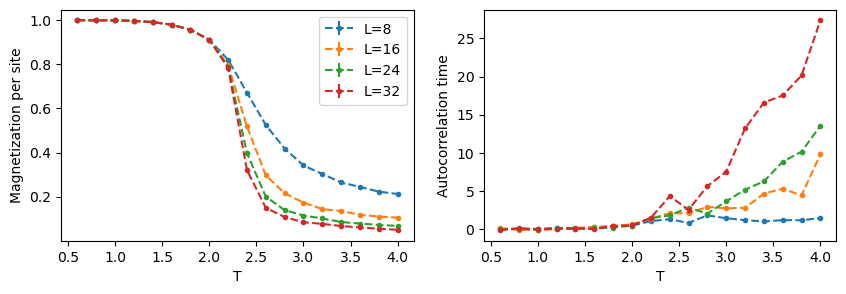

PyObject <matplotlib.legend.Legend object at 0x7fab207d4970>

In [34]:
fig, ax = subplots(1,2, figsize=(10,3))
for (j, L) in enumerate(Ls)
    ax[1].errorbar(Ts,m[:,j],dm[:,j], marker=".", linestyle="dashed", label="L="*string(L))
end
ax[1].set_xlabel("T")
ax[1].set_ylabel("Magnetization per site");

ax[2].plot(Ts, tau, "--.")
ax[2].set_xlabel("T")
ax[2].set_ylabel("Autocorrelation time");

ax[1].legend()


Dynamical critical exponent using Wolff cluster updates is 0.25


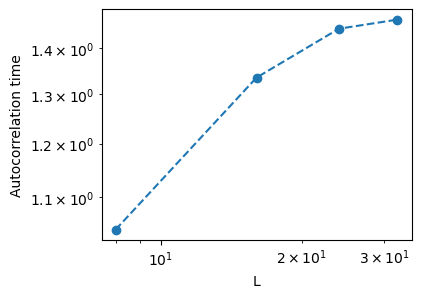

In [35]:
ind_Tc = 9
figure(figsize=(4,3))
plot(Ls, tau[ind_Tc,:], "--o")
xlabel("L")
ylabel("Autocorrelation time");
xscale("log")
yscale("log")

p = fit(log.(Ls), log.(tau[ind_Tc,:]), 1)
println("Dynamical critical exponent using Wolff cluster updates is ", round(p[1],digits = 2))

# Finite-size scaling

In [11]:
Tc=2/log(1+sqrt(2))

2.269185314213022

In [27]:
Ls = Int64[8, 16, 24, 32]
Ts = range(2.1, stop=2.5, step=0.05)

Neq = 100
Ntot = Neq*100

binder = zeros(length(Ts), length(Ls))
chi = zeros(length(Ts), length(Ls))
C = zeros(length(Ts), length(Ls))

for (j, L) in enumerate(Ls)
    
    lat = SquareLattice(L,L)
    for (k, T) in enumerate(Ts)
        
        m, En = IsingMC(lat, T, Ntot, true);
        m_eq = m[ Neq : end]
        En_eq = En[ Neq : end]
        binder[k,j] = mean(m_eq.^4)/(mean(m_eq.^2)^2)
        chi[k,j] = (mean(m_eq.^2) - mean(m_eq)^2)*L^2/T
        C[k,j] = (mean(En_eq.^2) - mean(En_eq)^2)/T^2
    end
end


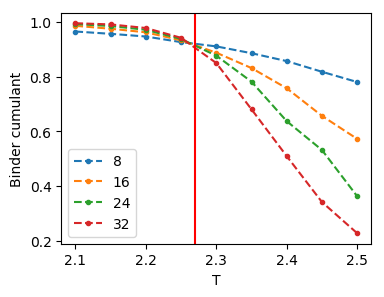

In [28]:
figure(figsize=(4,3))
plot(Ts, 3/2*(1 .- 1/3 * binder), "--.")
legend(map(L->string(L), Ls))
axvline(Tc, color="red")
xlabel("T")
ylabel("Binder cumulant");

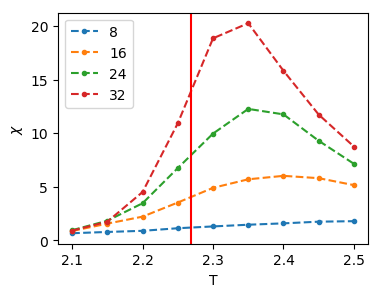

In [30]:
figure(figsize=(4,3))
plot(Ts, chi, "--.")
legend(map(L->string(L), Ls))
axvline(Tc, color="red")
xlabel("T")
ylabel(L"$\chi$");

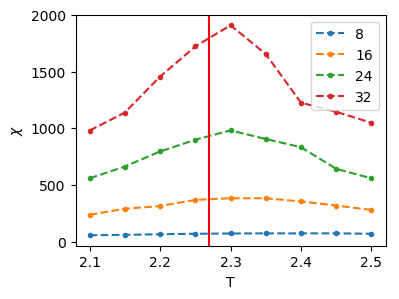

In [29]:
figure(figsize=(4,3))
plot(Ts, C, "--.")
legend(map(L->string(L), Ls))
axvline(Tc, color="red")
xlabel("T")
ylabel(L"$C_V$");

In [65]:
L = 16
lat = SquareLattice(L,L)
T = 3.
Ntot = 1000
m, En, configs = IsingMC(lat, T, Ntot, true, true);

In [66]:
size(configs)

(1000, 256)

In [88]:
Ls = Int64[16, 24, 32]

Ts = range(2.2, stop=2.5, step=0.01)

Neq = 100
Ntot = Neq*100

binder = zeros(length(Ts), length(Ls))
chi = zeros(length(Ts), length(Ls))
C = zeros(length(Ts), length(Ls))

for (j, L) in enumerate(Ls)
    
    lat = SquareLattice(L,L)
    for (k, T) in enumerate(Ts)
        
        @show L, T
        @time m, En = IsingMC(lat, T, Ntot, true);
        m_eq = m[ Neq : end]
        En_eq = En[ Neq : end]
        binder[k,j] = mean(m_eq.^4)/(mean(m_eq.^2)^2)
        chi[k,j] = (mean(m_eq.^2) - mean(m_eq)^2)*L^2/T
        C[k,j] = (mean(En_eq.^2) - mean(En_eq)^2)/T^2
    end
end


(L, T) = (16, 2.2)
  1.015166 seconds (9.53 M allocations: 1.105 GiB, 11.36% gc time)
(L, T) = (16, 2.21)
  1.059874 seconds (9.48 M allocations: 1.098 GiB, 12.08% gc time)
(L, T) = (16, 2.22)
  1.010266 seconds (9.46 M allocations: 1.094 GiB, 11.66% gc time)
(L, T) = (16, 2.23)
  0.921013 seconds (9.41 M allocations: 1.087 GiB, 11.78% gc time)
(L, T) = (16, 2.24)
  0.892853 seconds (9.38 M allocations: 1.083 GiB, 12.12% gc time)
(L, T) = (16, 2.25)
  0.868238 seconds (9.32 M allocations: 1.074 GiB, 11.85% gc time)
(L, T) = (16, 2.26)
  0.860845 seconds (9.29 M allocations: 1.070 GiB, 12.24% gc time)
(L, T) = (16, 2.27)
  0.963912 seconds (9.25 M allocations: 1.064 GiB, 12.56% gc time)
(L, T) = (16, 2.28)
  0.853687 seconds (9.19 M allocations: 1.054 GiB, 13.03% gc time)
(L, T) = (16, 2.29)
  0.813412 seconds (9.13 M allocations: 1.046 GiB, 13.06% gc time)
(L, T) = (16, 2.3)
  0.832083 seconds (9.10 M allocations: 1.041 GiB, 12.51% gc time)
(L, T) = (16, 2.31)
  0.887935 seconds (9.07 

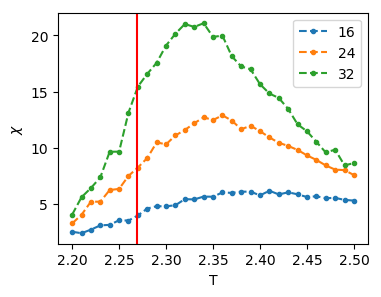

In [89]:
figure(figsize=(4,3))
plot(Ts, chi, "--.")
legend(map(L->string(L), Ls))
axvline(Tc, color="red")
xlabel("T")
ylabel(L"$\chi$");

In [117]:
TcL = map(j -> Ts[argmax(chi[:,j])], range(1, length=length(Ls)))
p = fit(log.(Ls), log.(TcL .- Tc), 1)
println("(T*-Tc) vs L exponent is ", round(p[1], digits=3), " (expected -1)")

(T*-Tc) vs L exponent is -0.998 (expected -1)


In [118]:
chi_max = map(j -> maximum(chi[:,j]), range(1, length=length(Ls)))
p = fit(log.(Ls), log.(chi_max), 1)
println("chi_max vs L exponent is ", round(p[1], digits=3), " (expected 7/4)")

chi_max vs L exponent is 1.773 (expected 7/4)
